Ideas are related temporally.  This notebook explores the git history to quantify weekly activity on the 
deathbeds blog.

In [10]:
    import git, pandas, pathlib, networkx, matplotlib.pyplot

In [3]:
    repo = git.Repo('..')
    commits = pandas.Series(repo.iter_commits())

compute the files `changed` for each of the `commits` in the `repo`.

In [4]:
    # This takes time.
    changed = commits.apply(lambda x: pandas.Series(x.stats.files))

Create a tidy `df` to hold the weekly file changes.

In [17]:
    df = changed.stack().apply(pandas.Series).reset_index(-1).rename(columns={
        'level_1': 'name'
    }).join(commits.apply(lambda x: x.committed_datetime).rename('time')).pipe(
        lambda df: df.set_index(pandas.to_datetime(df['time'], utc=True))    
    ).groupby(['name', pandas.Grouper(freq='W')]).agg({
        'lines': pandas.Series.count, 'insertions': 'sum', 'deletions': 'sum'
    }).rename(columns=dict(lines='changes')).unstack('time').fillna(0)
    df = df[df.index.str.endswith('.ipynb')]

Separate the `changes`, `insertions`, and `deletions` for each of the files.  

In [18]:
    changes, insertions, deletions = (df[object] for object in 'changes insertions deletions'.split())

We'll only continue forward with `changes`.

Create & draw the `networkx.Graph`.

In [19]:
    G = (
        changes.set_index(changes.index.rename('source')) 
        @ changes.set_index(changes.index.rename('target')).T).pipe(
        lambda df: df-(pandas.np.eye(len(df))*pandas.np.diag(df))
    )
    G = G.divide(G).stack().to_frame('value').reset_index().pipe(networkx.from_pandas_edgelist)


A view of the connectivity of the files. Some clustering of ideas have a longer continuity than others.  Newer ideas haven't been able to be come parts of larger ideas yet.

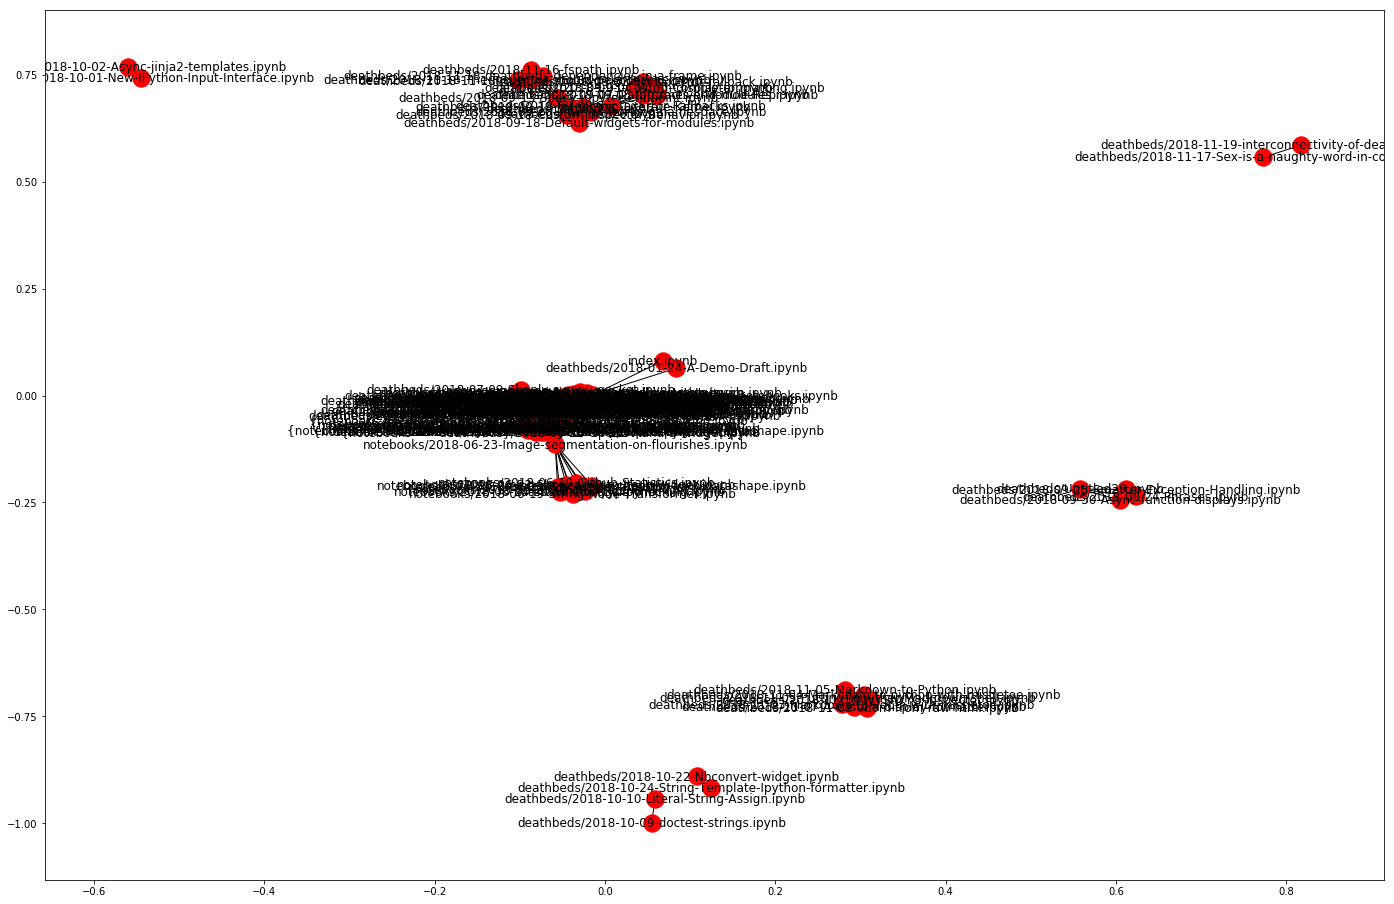

In [22]:
    networkx.draw_networkx(G)
    matplotlib.pyplot.gcf().set_size_inches(24, 16)